Reference:
https://www.hackerearth.com/blog/developers/jazz-music-using-deep-learning

In this example notebook we will focus on $\textit{Generativ Adversional Networks}$ (GAN-s). The main focus for GAN is generating new data, f.e. photographs that look at least superficially authentic to human observers. GAN-s were introduced by Ian Goodfellow in 2014.


Problem
In tradicional Neural Network we use it to perform a task of clasyfication, for a given set $D = \{(x_n, y_n)\}_{n=1}^N$ classify $\textit{y}$ for the new $\textbf{x}$. In GAN-s insted of classyfing we use our NN to create new data. To perform it we have to compose 2 neural netorks:

Gnerator to create new data
Discriminator to say if our fake (generated) data is good enough

$\textbf{Generator}$ is a NN that take some random noise (or some real data in more sofisticated GAN examples) and creates from it brand new data that seems to be real.

![alt text](img/generator_example_1.jpeg "Generator")


$\textbf{Discriminator}$ is a NN that take data from generator and decide if is is well enough faked. Discriminator Network gets real data examples and fake data examples, we lrarn in to know which example is real and which is fake. At the end we want to get "so good" faked data that discriminator never will be sure if is it fake or true.

![alt text](img/discriminator_example_1.png "Generator")

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import glob
#importing library
from collections import Counter
from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional, LSTM
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import pretty_midi

%matplotlib inline

Using TensorFlow backend.


Reading the midi files and getting pitch value, We will predict pitch

In [22]:
def get_notes():
    """ Get all the notes from the midi files """
    notes = []
    for file in glob.glob("midi_songs/*.mid"):
        midi = pretty_midi.PrettyMIDI(file)
        for instrument in midi.instruments:
            # We just need to look for drum
            if instrument.is_drum:
                for note in instrument.notes:
                    notes.append(note.pitch)
    return notes

In [23]:
notes = get_notes()
n_vocab = len(set(notes))
print (set(notes))

{22, 26, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59}


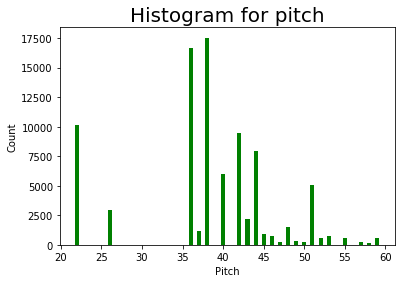

In [24]:
freq = dict(Counter(notes))
key = []
val = []
for elem in sorted(freq.items(), reverse=False) :
    key.append(elem[0])
    val.append(elem[1])

#set figure
f, ax = plt.subplots(1,1)
plt.bar(key, val, width=.5, color='g')
#set title & axis titles
ax.set_title('Histogram for pitch', fontsize=20)
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
plt.show()

In [25]:
def prepare_sequences(notes, sequence_length):
    print("\n**Preparing sequences for training**")
    pitchnames = sorted(set(i for i in notes)) # list of unique chords and notes
    n_vocab = len(pitchnames)
    print("Pitchnames (unique notes/chords from 'notes') at length {}: {}".format(len(pitchnames),pitchnames))
    # enumerate pitchnames into dictionary embedding
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    print("Note to integer embedding created at length {}".format(len(note_to_int)))

    network_input = []
    network_output = []

    # i equals total notes less declared sequence length of LSTM (ie 5000 - 100)
    # sequence input for each i is list of notes i to end of sequence length (ie 0-100 for i = 0)
    # sequence output for each i is single note at i + sequence length (ie 100 for i = 0)
    for i in range(0, len(notes) - sequence_length,1):
        sequence_in = notes[i:i + sequence_length] # 100
        sequence_out = notes[i + sequence_length] # 1

        # enumerate notes and chord sequences with note_to_int enumerated encoding
        # network input/output is a list of encoded notes and chords based on note_to_int encoding
        # if 100 unique notes/chords, the encoding will be between 0-100
        input_add = [note_to_int[char] for char in sequence_in]
        network_input.append(input_add) # sequence length
        output_add = note_to_int[sequence_out]
        network_output.append(output_add) # single note

    print("Network input and output created with (pre-transform) lengths {} and {}".format(len(network_input),len(network_output)))
    # print("Network input and output first list items: {} and {}".format(network_input[0],network_output[0]))
    # print("Network input list item length: {}".format(len(network_input[0])))
    n_patterns = len(network_input) # notes less sequence length
    print("Lengths. N Vocab: {} N Patterns: {} Pitchnames: {}".format(n_vocab,n_patterns, len(pitchnames)))
    print("\n**Reshaping for training**")

    # convert network input/output from lists to numpy arrays
    # reshape input to (notes less sequence length, sequence length)
    # reshape output to (notes less sequence length, unique notes/chords)
    network_input_r = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_output_r = np_utils.to_categorical(network_output)

    print("Reshaping network input to (notes - sequence length, sequence length) {}".format(network_input_r.shape))
    print("Reshaping network output to (notes - sequence length, unique notes) {}".format(network_output_r.shape))
    return network_input_r, network_output_r, n_patterns, n_vocab, pitchnames


In [26]:
network_input, network_output, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)
#print (network_input, network_output)


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 22: [22, 26, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59]
Note to integer embedding created at length 22
Network input and output created with (pre-transform) lengths 85977 and 85977
Lengths. N Vocab: 22 N Patterns: 85977 Pitchnames: 22

**Reshaping for training**
Reshaping network input to (notes - sequence length, sequence length) (85977, 22, 1)
Reshaping network output to (notes - sequence length, unique notes) (85977, 22)



## GAN Creation

One network generates candidates (generative) and the other evaluates them (discriminative). Generating Gaussian distribution is verry simple example so we can use verry simple Networks (both Genrator and Discriminator)
![alt text](img/gan_example_3.png)

####  Generator
Generator will contain only one layer
![alt text](img/generator_example_2.png)


####  Discriminator
Discriminator will contain 2 layers
![alt text](img/dsicriminator_example_2.png)

#### GAN Creation
GAN composes discriminator and genrator but the discriminator weights ale not trainable. GAN model we will use to train Generator to generate distributions

![alt text](img/gan_example_4.png)


In [27]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = rows
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='sigmoid'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, notes, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        #notes = get_notes()
        n_vocab = len(set(notes))
        X_train, y_train, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)
        #print (X_train, y_train)
        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
        #self.generate(notes)
        self.plot_loss()
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

In [28]:
gan = GAN(rows=n_vocab)    
gan.train(epochs=25, notes=notes, batch_size=50, sample_interval=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 512)           1052672   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.720409, acc.: 0.00%] [G loss: 0.653012]


/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.576083, acc.: 50.00%] [G loss: 0.619029]
2 [D loss: 0.501560, acc.: 50.00%] [G loss: 0.594670]
3 [D loss: 0.475820, acc.: 50.00%] [G loss: 0.588461]
4 [D loss: 0.461031, acc.: 50.00%] [G loss: 0.599410]
5 [D loss: 0.437326, acc.: 50.00%] [G loss: 0.620110]
6 [D loss: 0.423350, acc.: 50.00%] [G loss: 0.640087]
7 [D loss: 0.402559, acc.: 50.00%] [G loss: 0.662198]
8 [D loss: 0.388981, acc.: 50.00%] [G loss: 0.684375]
9 [D loss: 0.382567, acc.: 53.00%] [G loss: 0.702147]
10 [D loss: 0.353158, acc.: 91.00%] [G loss: 0.735543]
11 [D loss: 0.336170, acc.: 100.00%] [G loss: 0.789147]
12 [D loss: 0.299427, acc.: 100.00%] [G loss: 0.917913]
13 [D loss: 0.270710, acc.: 100.00%] [G loss: 1.210063]
14 [D loss: 0.133757, acc.: 100.00%] [G loss: 2.761796]
15 [D loss: 1.477166, acc.: 53.00%] [G loss: 1.123998]
16 [D loss: 0.186918, acc.: 100.00%] [G loss: 1.282414]
17 [D loss: 0.170981, acc.: 100.00%] [G loss: 1.528281]
18 [D loss: 0.152346, acc.: 98.00%] [G loss: 1.875240]
19 [D loss: 0

Generating music based on GAN network

In [31]:
def generate(gan, input_notes,n_vocab):
        # Get pitch names and store in a dictionary
        notes = input_notes
        
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        print (int_to_note)
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, gan.latent_dim))
        predictions = gan.generator.predict(noise)
        length = int(n_vocab/2)
        pred_notes = [x*length+length for x in predictions[0]]  
        #print (pred_notes)
        pred_notes = [int_to_note[int(x)] for x in pred_notes]
        return pred_notes

In [32]:
predictions = generate(gan,notes,n_vocab)
predictions

{0: 22, 1: 26, 2: 36, 3: 37, 4: 38, 5: 40, 6: 42, 7: 43, 8: 44, 9: 45, 10: 46, 11: 47, 12: 48, 13: 49, 14: 50, 15: 51, 16: 52, 17: 53, 18: 55, 19: 57, 20: 58, 21: 59}


[59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 57,
 55,
 59,
 59,
 59,
 53,
 58,
 59,
 57,
 58]

In [33]:
def create_midi(notes, filename):
    new_midi_data = pretty_midi.PrettyMIDI()
    drum = pretty_midi.Instrument(program=0, is_drum=True, name="Midi Drums" )
    time = 0
    step = 0.3
    len_notes = len(notes)
    vec_arr = np.random.uniform(50,125,len_notes)
    delta_arr = np.random.uniform(0.2,0.4,len_notes)
    for i,note_number in enumerate(notes):
        myNote = pretty_midi.Note(velocity=int(vec_arr[i]), pitch=int(note_number), start=time, end=time+delta_arr[i])
        drum.notes.append(myNote)
        time += step
    new_midi_data.instruments.append(drum)
    new_midi_data.write(filename)
    return new_midi_data

create_midi(predictions,'output/final.mid')

In [58]:

plot_noteSequence('output/final.mid', show_figure=True)

Loading BokehJS ...

In [35]:

import bokeh
import bokeh.plotting
from IPython import display
from magenta.music import midi_synth
import numpy as np
import pandas as pd
from scipy.io import wavfile
import six
from six.moves import urllib
import tensorflow.compat.v1 as tf
"""Generates a pandas dataframe from a sequence."""


In [13]:
import pygame

def play_music(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print ("Music file %s loaded!" % music_file)
    except pygame.error:
        #print "File %s not found! (%s)" % (music_file, pygame.get_error())
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)
# pick a midi music file you have ...
# (if not in working folder use full path)

midi_file = 'output/final.mid'
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)
try:
    play_music(midi_file)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
    raise SystemExit

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Music file output/final.mid loaded!
